In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 1000, threshold = 10000)

In [2]:
def MakeRotMat(omega, ct):
    nh = omega.nh_max
    Cosine = lambda k: np.cos(2. * np.pi * k * ct)
    Sine = lambda k: np.sin(2. * np.pi * k * ct)
    RotMat = lambda k: np.asarray([k, k, -k, k]).reshape(2, 2)
    rotMats = [RotMat(k) for k in range(int(nh / 2) + 1)]
    shift = LA2.block_diag(*rotMats)[1:-1, 1:-1]
    shift[0, 0] = 0
    shift[::-1, ::-1][0, 0] = int(nh / 2)
    return shift

In [3]:
c = 1.
CFL = 1.
nh = 2
cells = [[0], [0], [0], [0]]# , [9]]
omega = BT.Grid(nh)
nt = 2
for cell in cells:
    omega.AddPatch(2, cell)

In [4]:
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
print(t)

0.0625


In [5]:
waves = WT.MakeWaves(omega)


[[ 1.00000000e+00  9.78597633e-02  9.93586851e-01  1.93839179e-01  9.74495358e-01  2.86106072e-01  9.43165321e-01  3.72923229e-01  9.00316316e-01  4.52692443e-01  8.46927993e-01  5.23994577e-01  7.84213304e-01  5.85624475e-01  7.13585488e-01  6.36619772e-01  6.36619772e-01  6.76282781e-01  5.55010935e-01  7.04194890e-01  4.70527982e-01  7.20223104e-01  3.84967269e-01  7.24518620e-01  3.00105439e-01  7.17507549e-01  2.17653536e-01  6.99874143e-01  1.39213623e-01  6.72537106e-01  6.62391234e-02  6.36619772e-01]
 [ 1.00000000e+00  2.89818594e-01  9.55403866e-01  5.52007278e-01  8.26137274e-01  7.61883082e-01  6.25261286e-01  9.00316316e-01  3.72923229e-01  9.55697336e-01  9.41279718e-02  9.25042664e-01 -1.84002426e-01  8.14123810e-01 -4.35158243e-01  6.36619772e-01 -6.36619772e-01  4.12410330e-01 -7.71565459e-01  1.65227455e-01 -8.30654509e-01 -8.00459314e-02 -8.12719980e-01 -3.00105439e-01 -7.24518620e-01 -4.75663898e-01 -5.79598137e-01 -5.93324649e-01 -3.96446856e-01 -6.46691882e-01 -1.

[2 3 4 5]


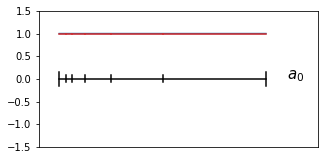

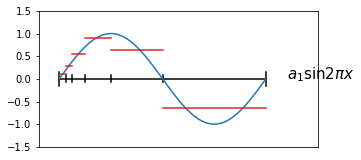

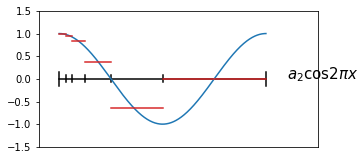

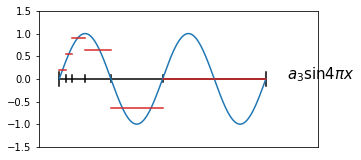

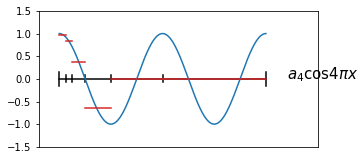

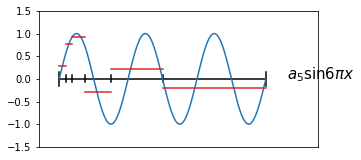

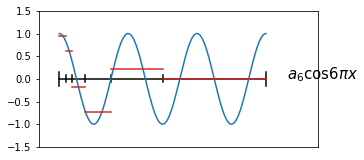

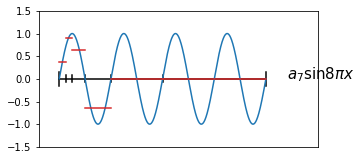

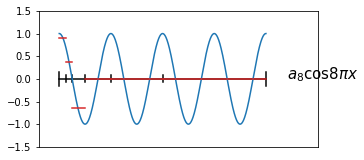

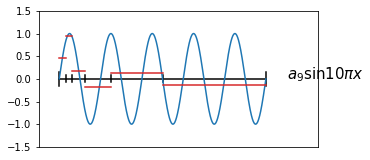

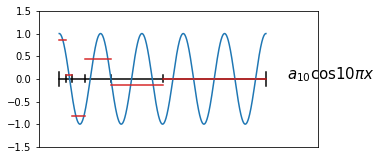

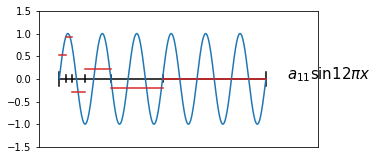

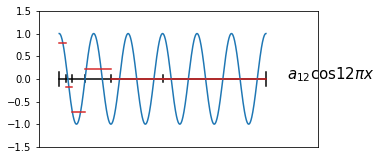

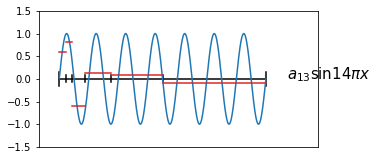

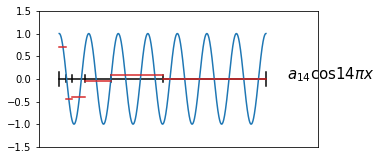

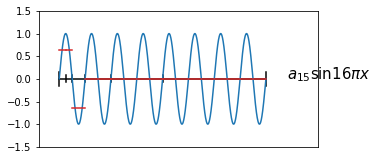

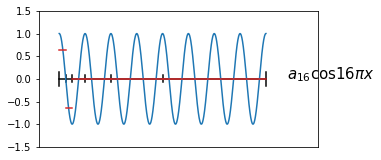

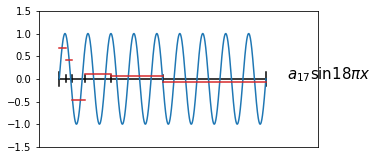

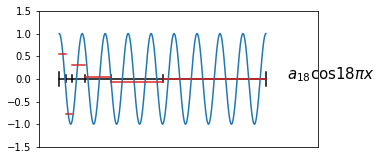

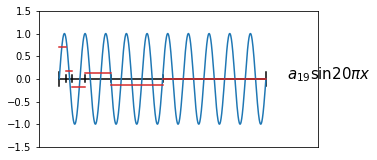

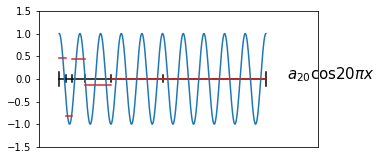

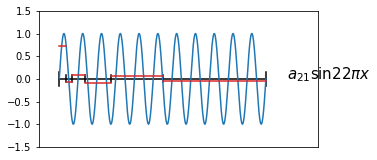

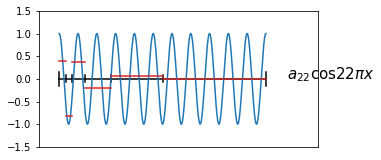

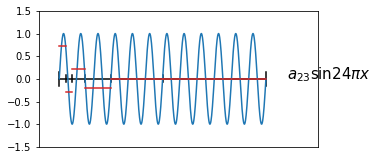

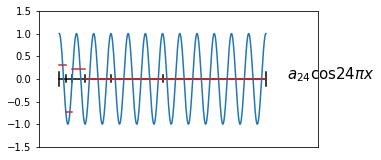

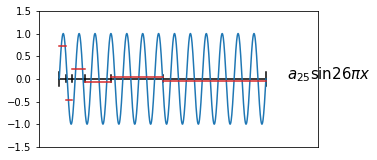

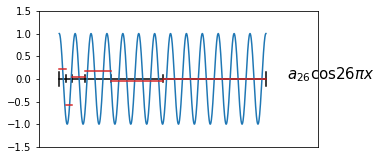

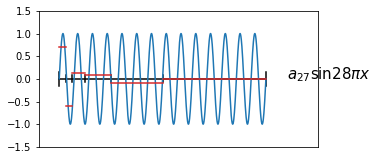

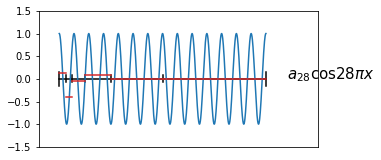

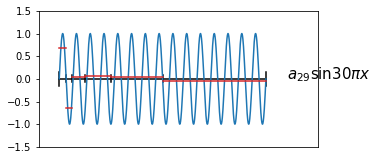

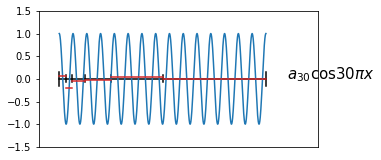

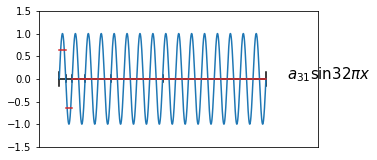

In [6]:
print(np.arange(2, 6))
PT.PlotWaves(omega, waves = waves)

In [7]:
 def PropWaves(omega, waves, c, t):
    nh2 = omega.nh_max
    nhs = omega.nh
    hs = omega.h
    levels = omega.levels
    refRatios = omega.refRatios
    rotMat = MakeRotMat(omega, c * t)
    backRotMat = rotMat[::-1, ::-1] + 0
    np.fill_diagonal(backRotMat[1:], np.diagonal(backRotMat, offset = 1))
    np.fill_diagonal(backRotMat[:, 1:], -np.diagonal(backRotMat, offset = 1))
    compRotMat = rotMat + 0
    compRotMat[::-1, ::-1][0, 0] = 0
    print(rotMat)
    h = 1. / nh2
    # aliasedWaves = int(nhs[0])
    fineSpots = np.where(hs == h)[0]
    wavesAlias = waves + 0
    # wavesAlias[:, :aliasedWaves] = 0
    wavesAlias[fineSpots, :] = 0
    workingWaves = waves - wavesAlias
    propMat = workingWaves @ rotMat
    print('nh =', nh2)
    print(workingWaves)
    refRatioTot = 1
    for q in range(levels):
        nh0 = nhs[::-1][q + 1]
        if (q == 0):
            nh1 = nh0
        refRatio = refRatios[::-1][q]
        refRatioTot = refRatioTot * refRatio
        print('nh = ', nh0)
        h = 1. / nh0
        for p in range(refRatioTot - 1):
            s0 = 2 * (p % 2)
            startPoint = nh0 * (p + 1) - s0
            endPoint = startPoint + nh0 + s0
            compRotMat[startPoint + 1:endPoint - 1, startPoint + 1:endPoint - 1] = backRotMat[nh2 - nh0 - s0 + 1:nh2 - 1, nh2 - nh0 - s0 + 1:nh2 - 1]
        workingWaves = wavesAlias + 0
        fineSpots = np.where(hs != h)[0]
        workingWaves[fineSpots, :] = 0
        propMat = propMat + (workingWaves @ backRotMat)
        wavesAlias = wavesAlias - workingWaves
        print(compRotMat)
        print('workingWaves')
        print(workingWaves)
    print('\nSTOP!\n')
    return propMat
blah = PropWaves(omega, waves, c, t)
propWaves = FFTT.PropWaves(omega, waves, c, t)
nullspace = OT.FindNullspace(omega, propWaves, shift = True)


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  -1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   2   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  -2   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  -3   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   4   4   0   0   0   0   0   0   0   0   0   0   0  

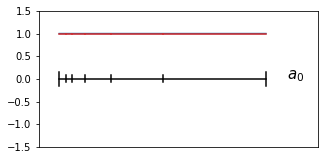

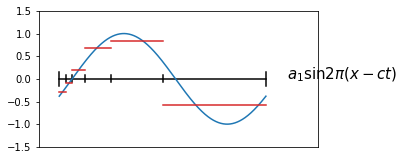

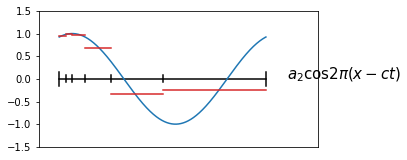

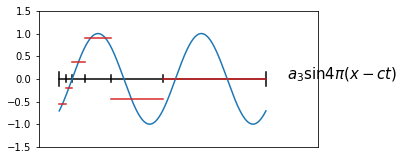

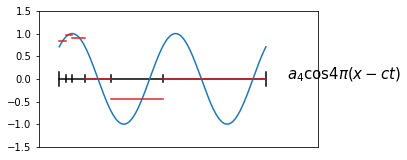

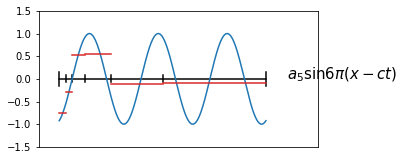

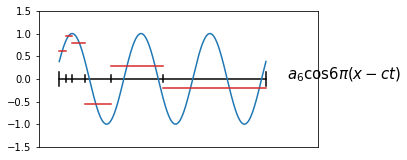

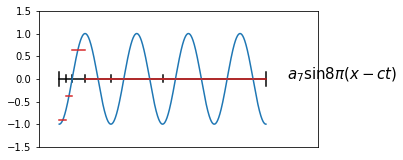

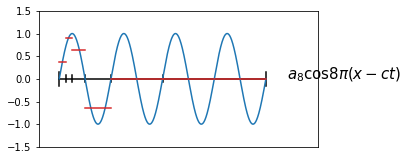

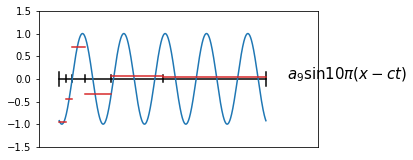

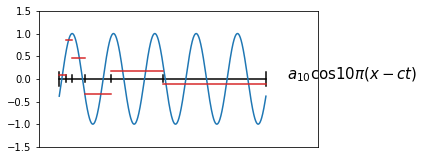

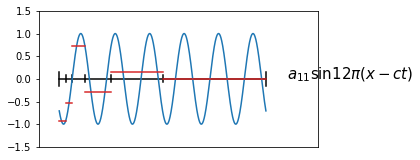

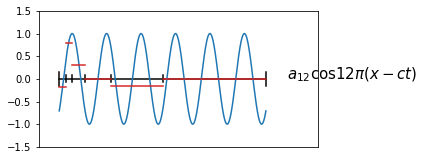

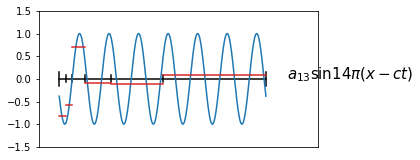

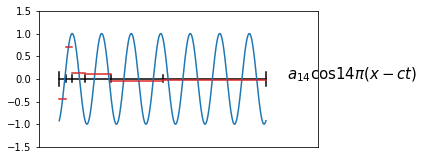

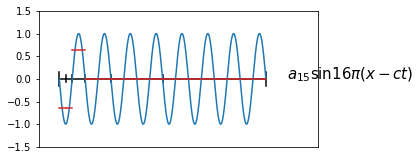

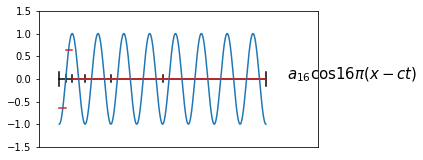

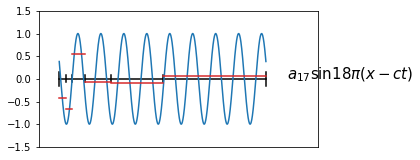

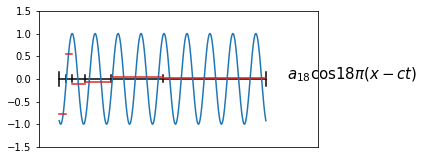

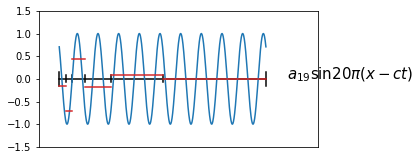

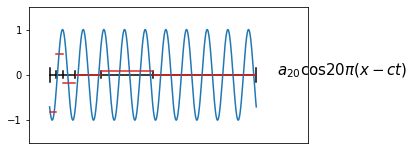

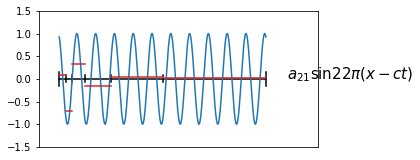

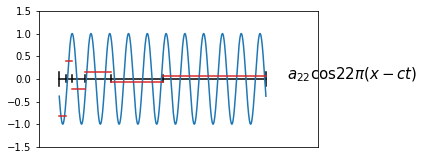

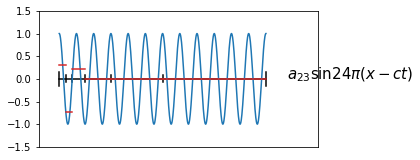

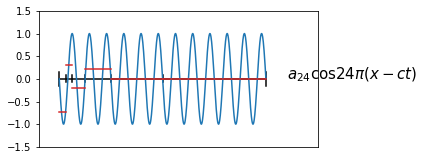

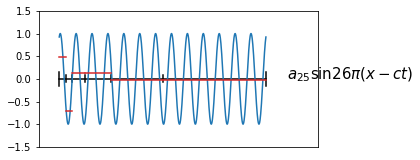

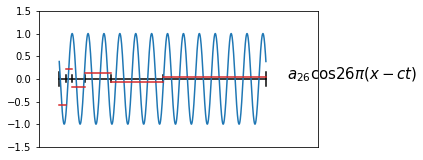

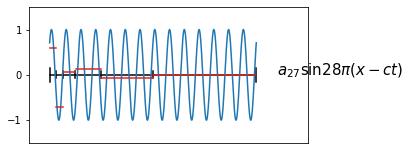

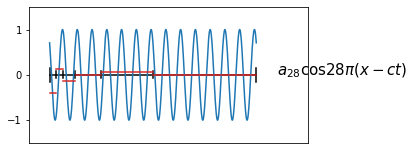

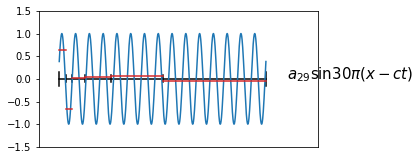

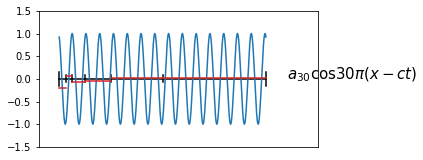

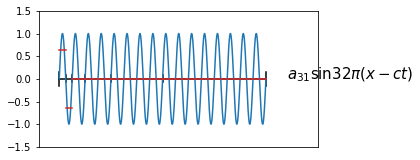

In [8]:
# print(np.where(nullspace != 0)[1])
PT.PlotWaves(omega, waves = propWaves, ct = c * t)

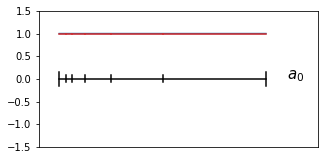

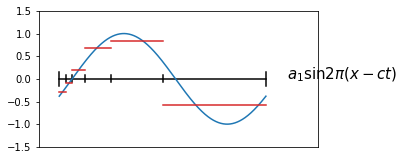

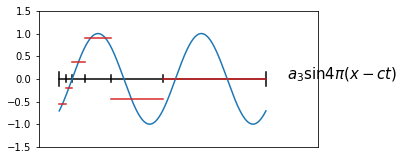

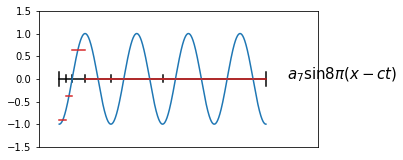

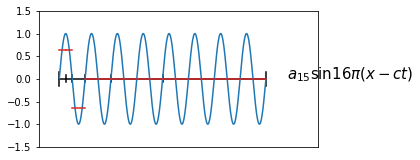

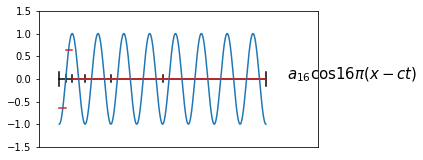

In [9]:
PT.PlotWaves(omega, waves = propWaves, nullspace = nullspace, ct = c * t)

In [10]:
A = MakeRotMat(omega)
B = A[::-1, ::-1] + 0 # np.roll(A, 1, axis = 0)
np.fill_diagonal(B[1:], np.diagonal(B, offset = 1))
np.fill_diagonal(B[:, 1:], -np.diagonal(B, offset = 1))
C = np.roll(B, 7, axis = 0)
C = np.roll(C, 7, axis = 1)

TypeError: MakeRotMat() missing 1 required positional argument: 'ct'

In [ ]:
print('A =\n', A)
print('')
print('B =\n', B)
print('')
print('C =\n', C)
print('')